In [1]:
#imports
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm
import sys
import datetime
sys.path.insert(0, '..')
from models import Classifier
from losses import WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger

np.random.seed(42)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device= "cpu"
print('device used in training:', device)

device used in training: cuda:0


In [2]:
def plot_stuff(model_legendre,Y,bins=50,title="DNN"):  
        validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
        cuts = []
        efficiencies = np.linspace(0.1,0.9,9)
        for eff in efficiencies:
            cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
        scores = np.array(model_legendre(Y).tolist())
    
        R50 = 1/((scores[y_test==1]<cuts[4]).sum()/(y_test==1).sum())
        
        sorted_m = np.argsort(m_t)
        m = m_t[sorted_m].reshape(bins,-1).mean(axis=1)
        scores = scores[sorted_m].reshape(bins,-1)
        F_s = []
        for s in scores:
            density = np.histogram(s,bins=50,range=(0,1))[0]
            F_s.append(np.cumsum(density)/density.sum())
        F_s = np.array(F_s).T
        fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
        for j,cut in enumerate(cuts):
            c = f"C{j}" if j!= 6 else f"C11"
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

        ax1.set_ylabel(r"False Pos. Rate",fontsize=17)
        ax1.text(-0.75,0.9,f"R50:{R50:.1f}",fontsize=17)
        ax1.set_ylim([-0.02,1.02])
        ax1.set_title(title, fontsize=17)
        ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

        _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, norm=LogNorm(), label="all",cmap='viridis',range=[[-1,1],[0,1]])
        cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
        cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
        cb.ax.set_title("counts")
        ax2.set_ylabel(r"$s$",fontsize=17)

        im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
        ax3.set_ylabel(r"$s$",fontsize=17)

        cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
        cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
        cb.ax.set_title(r"$F(s)$")
        ax3.set_xlabel(r"$m$",fontsize=19)

        fig.tight_layout(pad=0)
        plt.show()
        return
class Model(Classifier):
    def __init__(self,input_size=10,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size,16)
        self.linear1 = torch.nn.Linear(16,32)
        self.linear2 = torch.nn.Linear(32,64)
        self.linear3 = torch.nn.Linear(64,128)
        #self.batchnorm = torch.nn.BatchNorm1d(64)
        self.linear4 = torch.nn.Linear(128,265)
        self.out = torch.nn.Linear(265,1)
        # Defaults
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-3)
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = torch.nn.functional.relu(self.linear(x))
#         x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        #x = self.batchnorm(x)
        x = torch.nn.functional.relu(self.linear3(x))
        x = torch.nn.functional.relu(self.linear4(x))
        x = torch.sigmoid(self.out(x))
        return x

In [3]:
class Scheduler(torch.optim.lr_scheduler.ReduceLROnPlateau):
    def __repr__(self):
        
        keys = ['patience','factor', 'min_lr', 'cooldown', 
                'mode', 'threshold', 'threshold_mode', 'verbose']
        values = [self.patience, self.factor, self.min_lrs,  
                  self.cooldown, self.mode, self.threshold, 
                self.threshold_mode,self.verbose]
        string = self.__class__.__name__ +"(\n"
        for key,value in zip(keys,values):
            string += f"     {key}: {value}\n"
        string += ')'
        return string

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

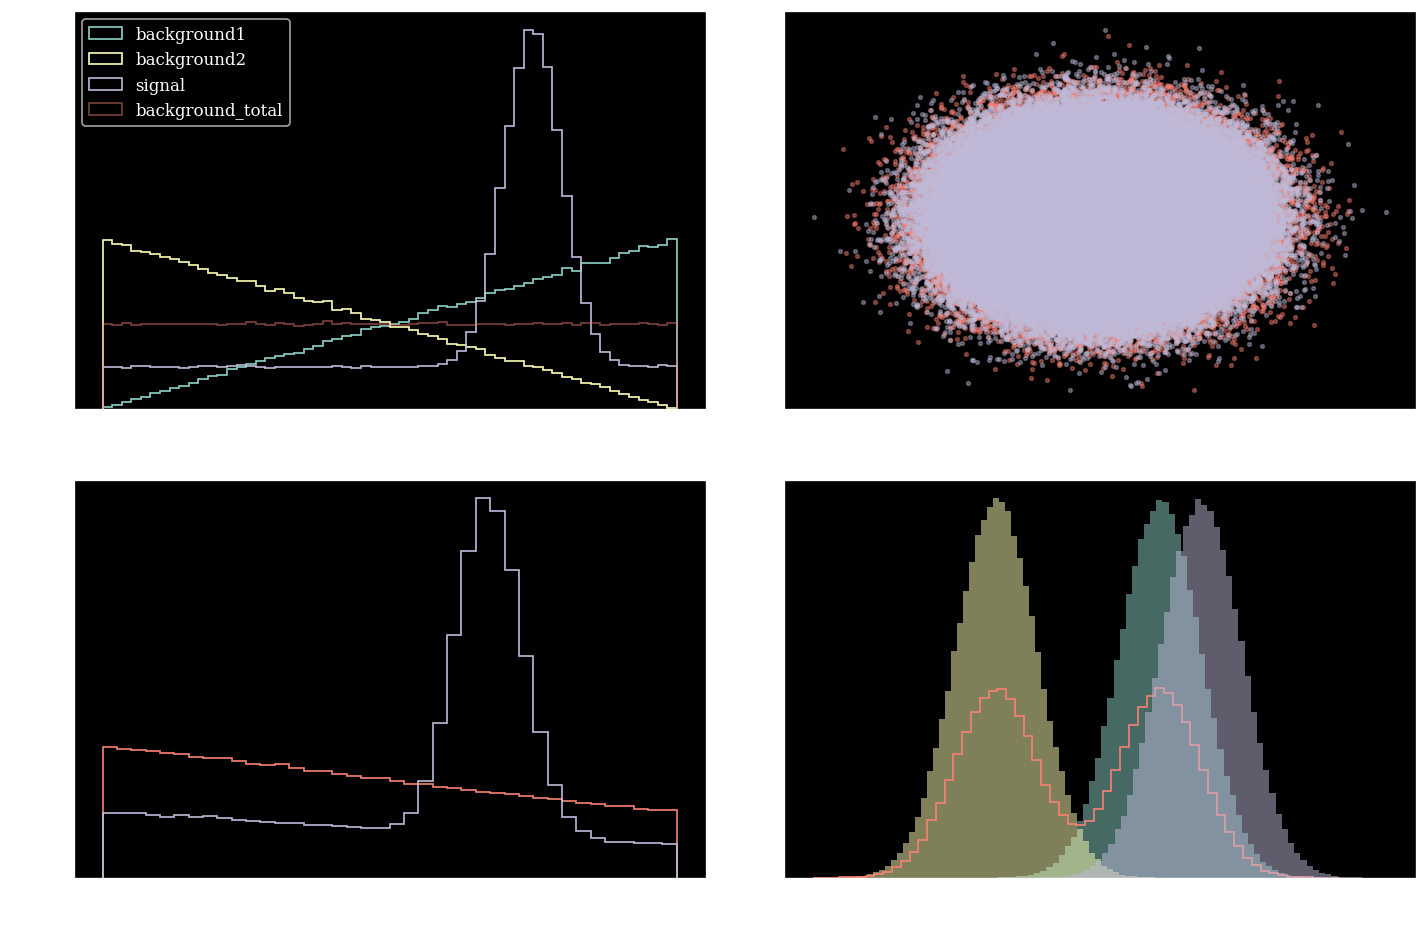

In [4]:
# data
n_s = int(5e5)
n_b = int(5e5/2)
n_s_gauss_frac = 0.5

a = 1/2 
b = 1/2
a2 = -1/2 
b2 = 1/2

u = np.random.uniform(0,1,n_b)
u2 = np.random.uniform(0,1,n_b)
u_ = np.random.uniform(0,1,n_b)

m_b1 = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_b2= - b2/(a2) + np.sqrt((b2-a2)**2 + 2*a2*u2)/(a2)
m_b = np.concatenate([m_b1,m_b2])
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t1 = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t2 = - b2/(a2) + np.sqrt((b2-a2)**2 + 2*a2*u_)/(a2)
m_t  = np.concatenate([m_t1,m_t2])

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=2*n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=2*n_b).T

z_b1 = np.random.normal(0,1,n_b)
z_b2 = np.random.normal(-4,1,n_b)
z_b  = np.concatenate([z_b1,z_b2])
z_s  = np.random.normal(1,1,n_s)
z_t  = np.concatenate([np.random.normal(0,1,n_b),np.random.normal(-4,1,n_b)])

fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

_,bins,_ = ax1.hist(m_b1,bins=60,density=True,alpha=1, label='background1',histtype="step")
ax1.hist(m_b2,bins=bins,density=True,alpha=1, label='background2',histtype="step")
ax1.hist(m_s,bins=bins,density=True,alpha=1,label='signal',histtype="step")
ax1.hist(m_b,bins=bins,density=True,alpha=0.5,label='background_total',histtype="step")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$m$")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4,color="C3")
ax2.scatter(x_s,y_s,s=5,alpha=0.4,color="C2")
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")

_,bins,_ = ax3.hist(np.exp(m_b)+2*m_b,bins=40,density=True,alpha=1, label='background',histtype="step",color="C3")
ax3.hist(np.exp(m_s)+2*m_s,bins=bins,density=True,alpha=1,label='signal',histtype="step",color='C2')
ax3.set_xlabel(r"$exp(m) + 2m$")

ax4.hist(z_b1,bins=60,density=True,alpha=0.5, label='background1')
ax4.hist(z_b2,bins=60,density=True,alpha=0.5, label='background2')
ax4.hist(z_b,bins=60,density=True,alpha=1, label='background_total',histtype="step",color="C3")
ax4.hist(z_s,bins=60,density=True,alpha=0.5,label='signal')
ax4.set_xlabel(r"$z$")

#ax2.set_title("Data")
fig.tight_layout()
#plt.savefig("./plots/Data.pdf")
plt.show()

##############################################finalize 
x = np.concatenate([np.stack([m_s,
                              np.exp(m_s)+2*m_s,
                              x_s,y_s,z_s],axis=1),
                   np.stack([m_b,
                             np.exp(m_b)+2*m_b,
                             x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,
                   np.exp(m_t)+2*m_t,
                   x_t,y_t,z_t],axis=1) 
y_test = np.ones(x_test.shape[0])
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train.astype('float32')[:,1:],y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val.astype('float32')[:,1:],y_val.astype('int32'),x_val[::,0].astype('float32'))
traindataset2 = DataSet(x_train.astype('float32')[:,2:],y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset2 = DataSet(x_val.astype('float32')[:,2:],y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test[:,1:]).float().to(device)
testTensor2= torch.from_numpy(x_test[:,2:]).float().to(device)

In [5]:
my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])
now = datetime.datetime.now().strftime("%m-%d_%H-%M")

params = {'epochs'       : 100,
          'interval'     : 100,
          'batch_size'   : 8192*4,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    : True,
          'device'       : device,
          'pass_x_biased': True,
         }
lr = 1e-2

Entering Training...
Epoch:0001/0100  (5.9  s)
 Train: loss:0.1364, acc:79.6% || Val: loss: 0.1355, acc:79.7%, R50: 12.5387, 1/JSD: 12.0712
Epoch:0100/0100  (206.7s)
 Train: loss:0.1351, acc:79.7% || Val: loss: 0.1349, acc:79.8%, R50: 12.7741, 1/JSD: 12.0468


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


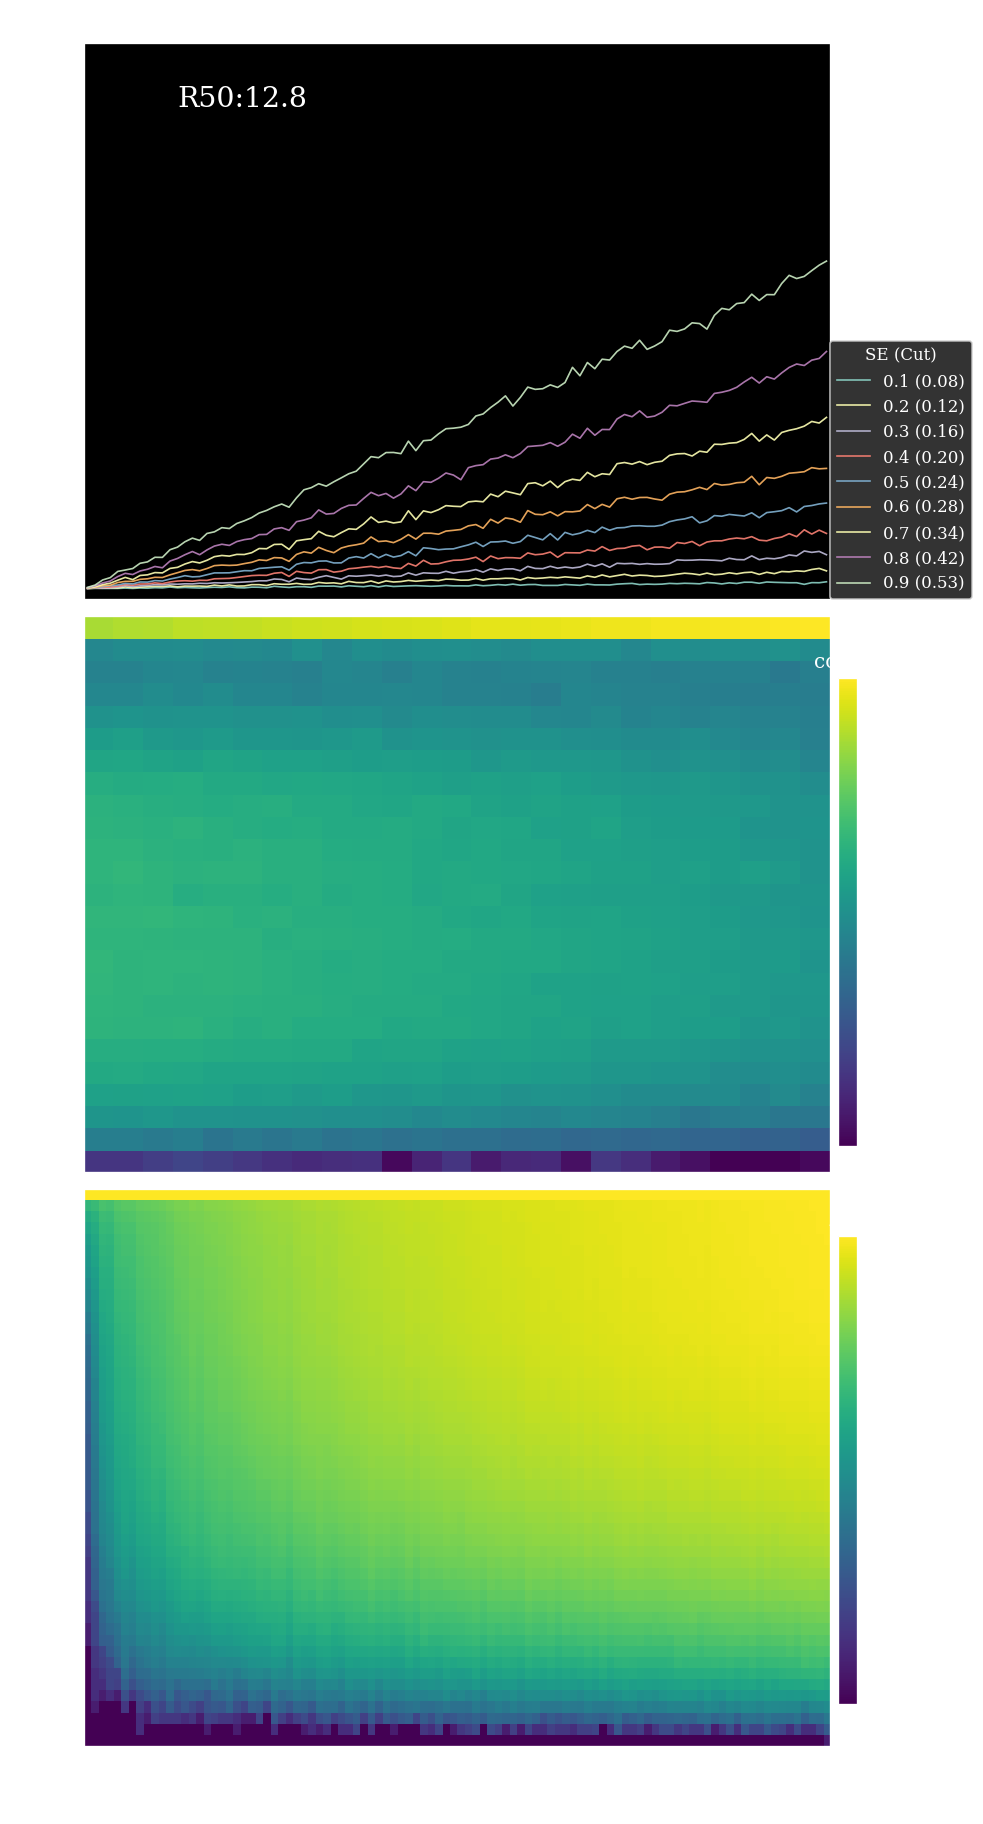

In [6]:
# Massless MSE
for i,frac in enumerate([0]):
    torch.manual_seed(777)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=traindataset2.samples.shape[1]).to(device)
    model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=20,order=1,sbins=2,
                                   background_only=True)
    model_legendre.fit(traindataset=traindataset2,
                       valdataset=valdataset2,
                       **params,
                       optimizer=torch.optim.Adam(model_legendre.parameters(),lr=lr),
                       #log=logger,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    model_legendre.train(False)
    plot_stuff(model_legendre,Y=testTensor2,
               title="Massless MSE (acc: {:.3})".format(metrics_val_legendre.accs[-1]),
               bins=100)
    break

Entering Training...
Epoch:0001/0100  (5.9  s)
 Train: loss:0.1235, acc:81.6% || Val: loss: 0.1234, acc:81.7%, R50: 18.2244, 1/JSD: 4.7288
Epoch:0100/0100  (207.6s)
 Train: loss:0.1181, acc:83.3% || Val: loss: 0.1182, acc:82.8%, R50: 20.8883, 1/JSD: 4.1263


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


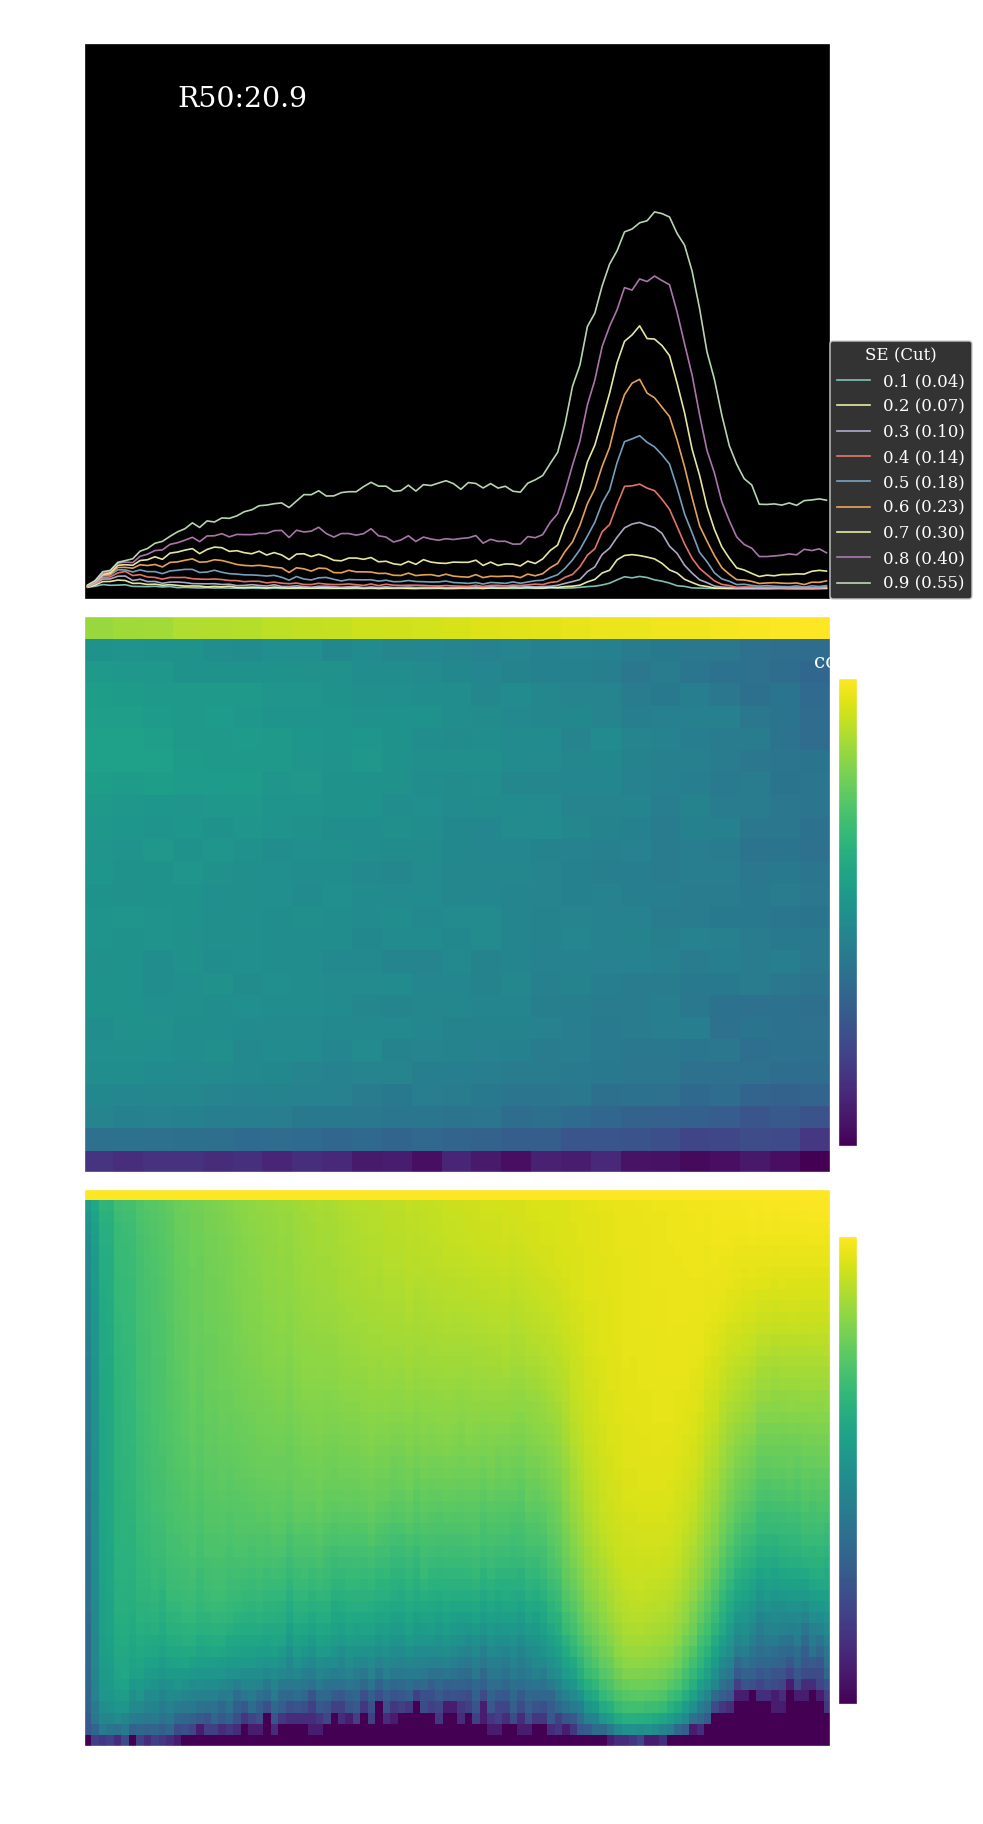

In [7]:
# Naive MSE
for i,frac in enumerate([0]):
    torch.manual_seed(777)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=traindataset.samples.shape[1]).to(device)
    model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=20,order=1,
                                   background_only=True)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.Adam(model_legendre.parameters(),lr=lr),
                       #log=logger,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    model_legendre.train(False)
    plot_stuff(model_legendre,Y=testTensor,
               title="Naive MSE (acc: {:.3})".format(metrics_val_legendre.accs[-1]),
               bins=100)

Entering Training...
Epoch:0001/0100  (5.7  s)
 Train: loss:0.1291, acc:81.4% || Val: loss: 0.1256, acc:81.3%, R50: 16.8862, 1/JSD: 7.5225
Epoch:0100/0100  (215.1s)
 Train: loss:0.1250, acc:82.5% || Val: loss: 0.1205, acc:82.2%, R50: 20.3860, 1/JSD: 5.8270


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


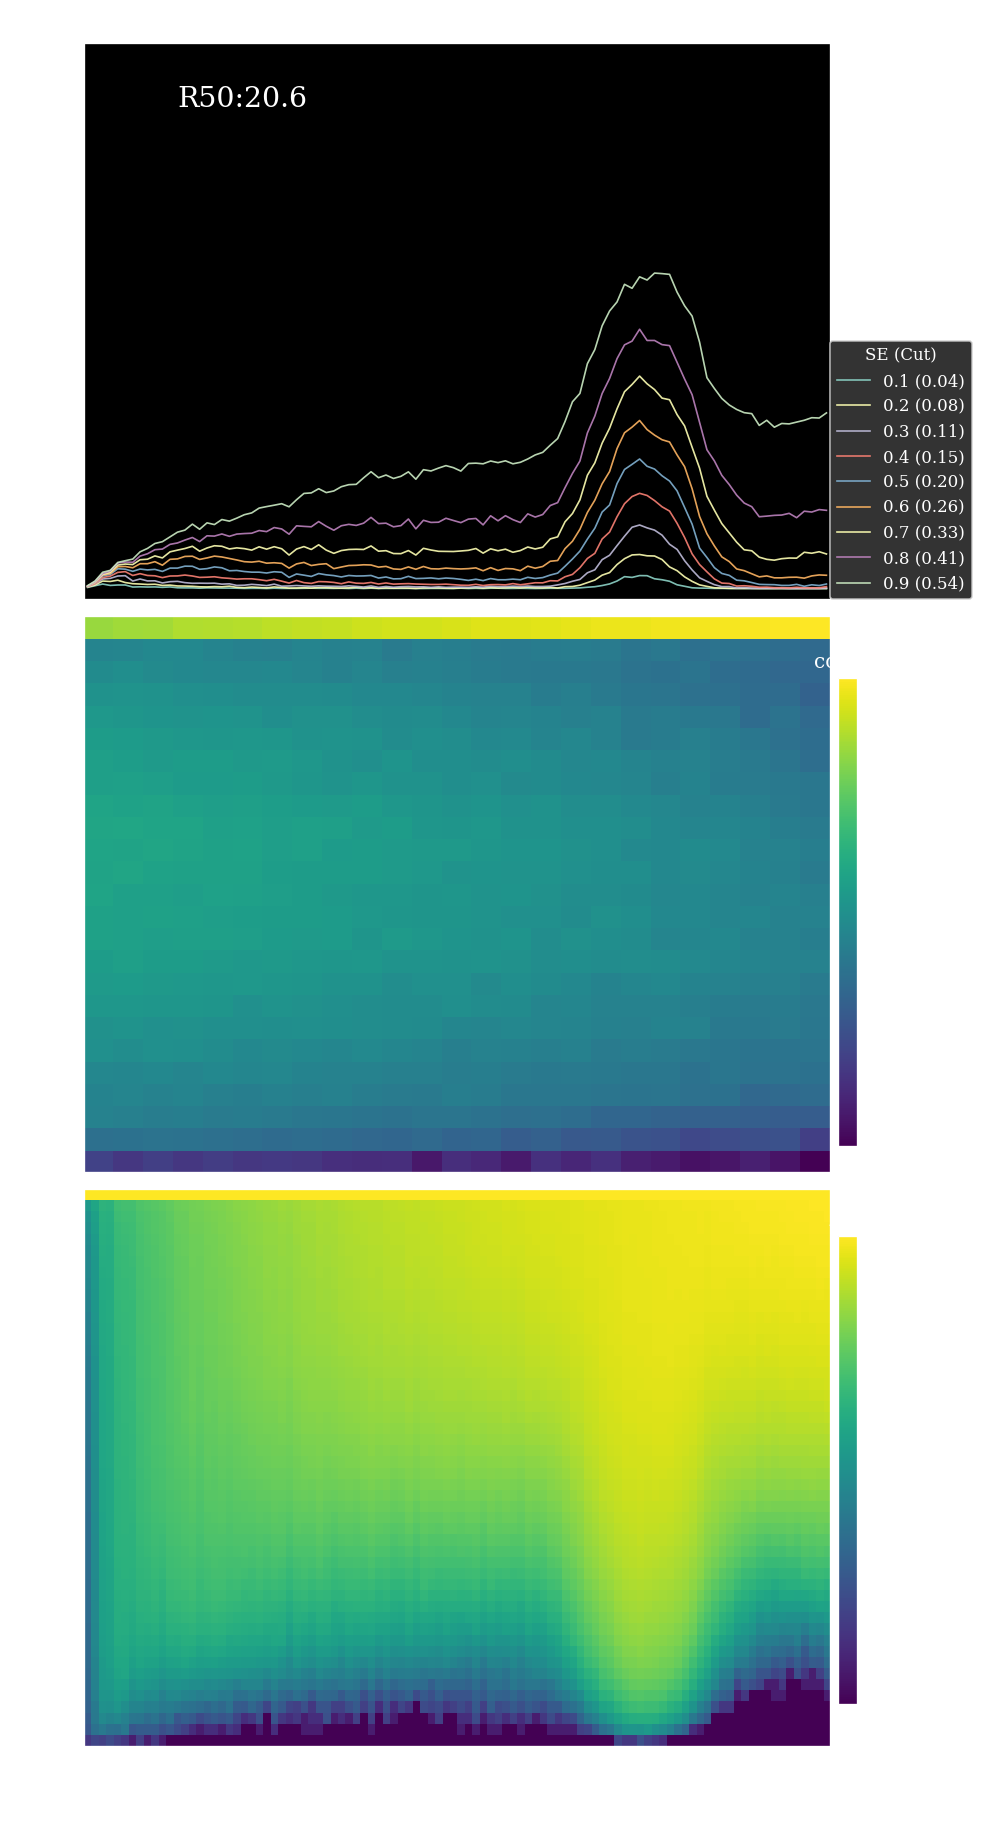

Entering Training...
Epoch:0001/0100  (5.7  s)
 Train: loss:0.1365, acc:80.2% || Val: loss: 0.1328, acc:80.0%, R50: 14.2743, 1/JSD: 17.9748
Epoch:0100/0100  (215.4s)
 Train: loss:0.1371, acc:80.4% || Val: loss: 0.1294, acc:80.4%, R50: 16.1841, 1/JSD: 24.3233


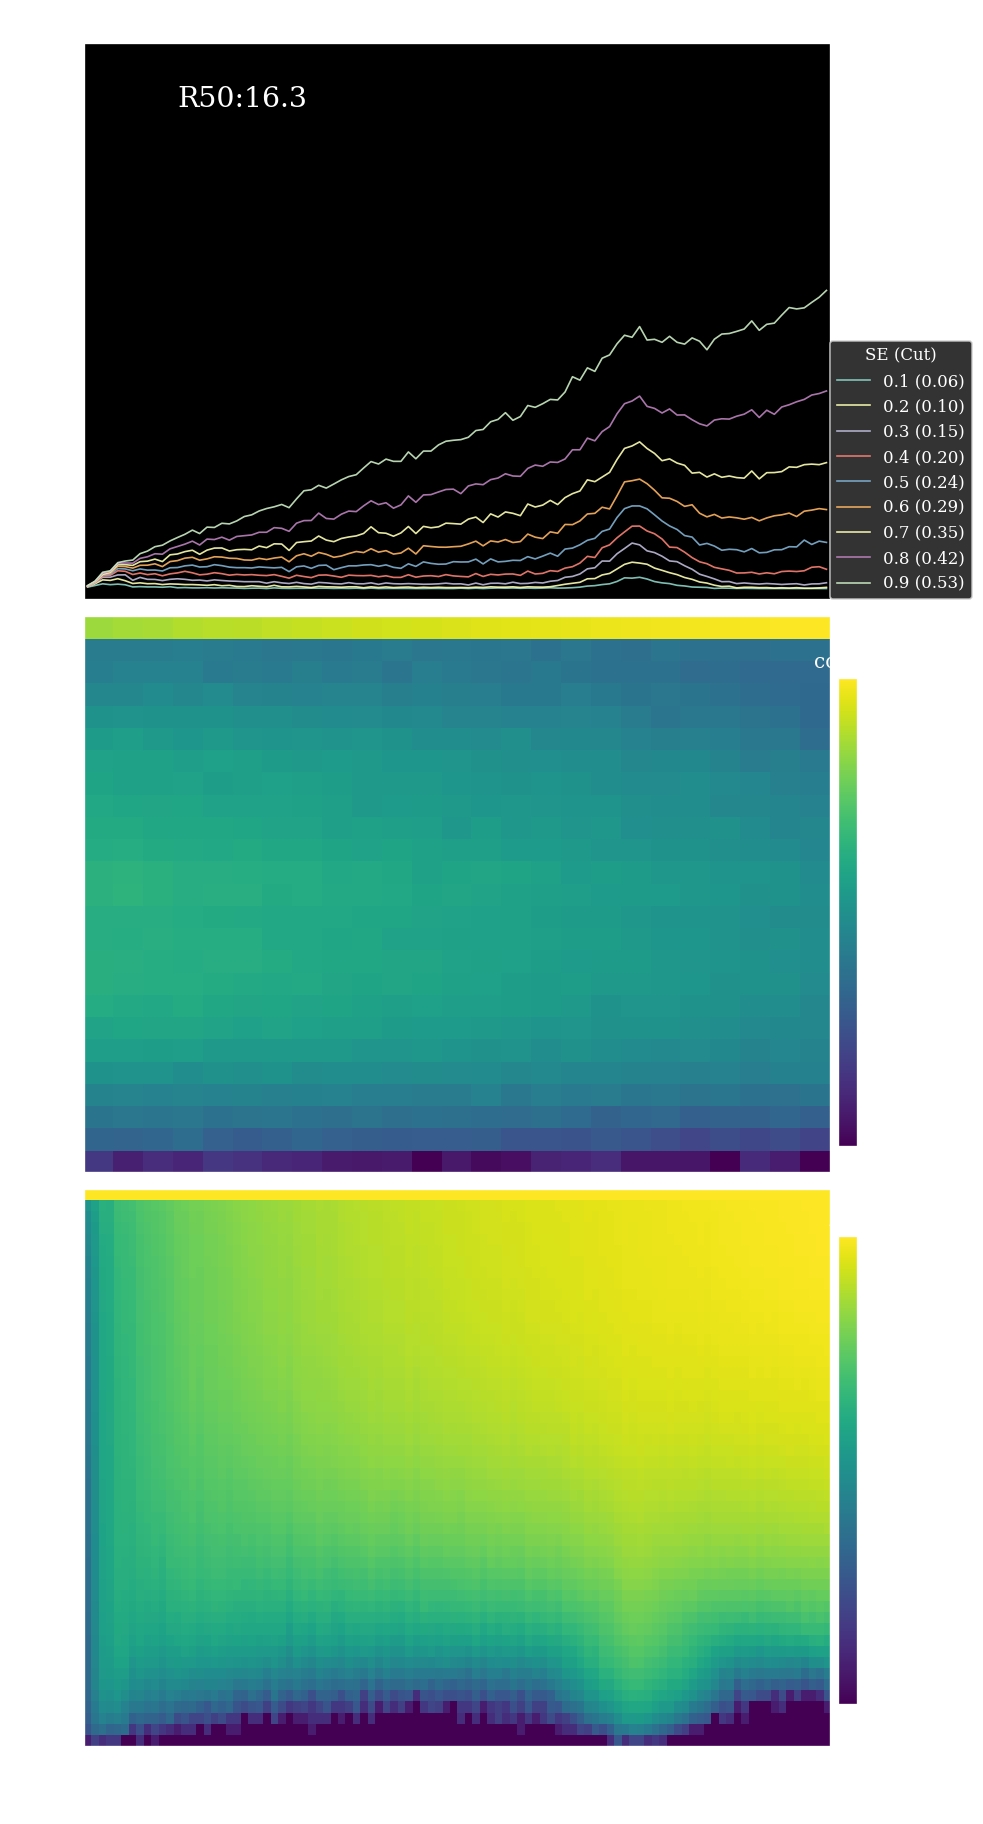

Entering Training...
Epoch:0001/0100  (5.7  s)
 Train: loss:0.1704, acc:79.8% || Val: loss: 0.1430, acc:79.7%, R50: 11.9102, 1/JSD: 16.4906
Epoch:0100/0100  (212.8s)
 Train: loss:0.1789, acc:80.1% || Val: loss: 0.1340, acc:80.0%, R50: 13.6268, 1/JSD: 27.5506


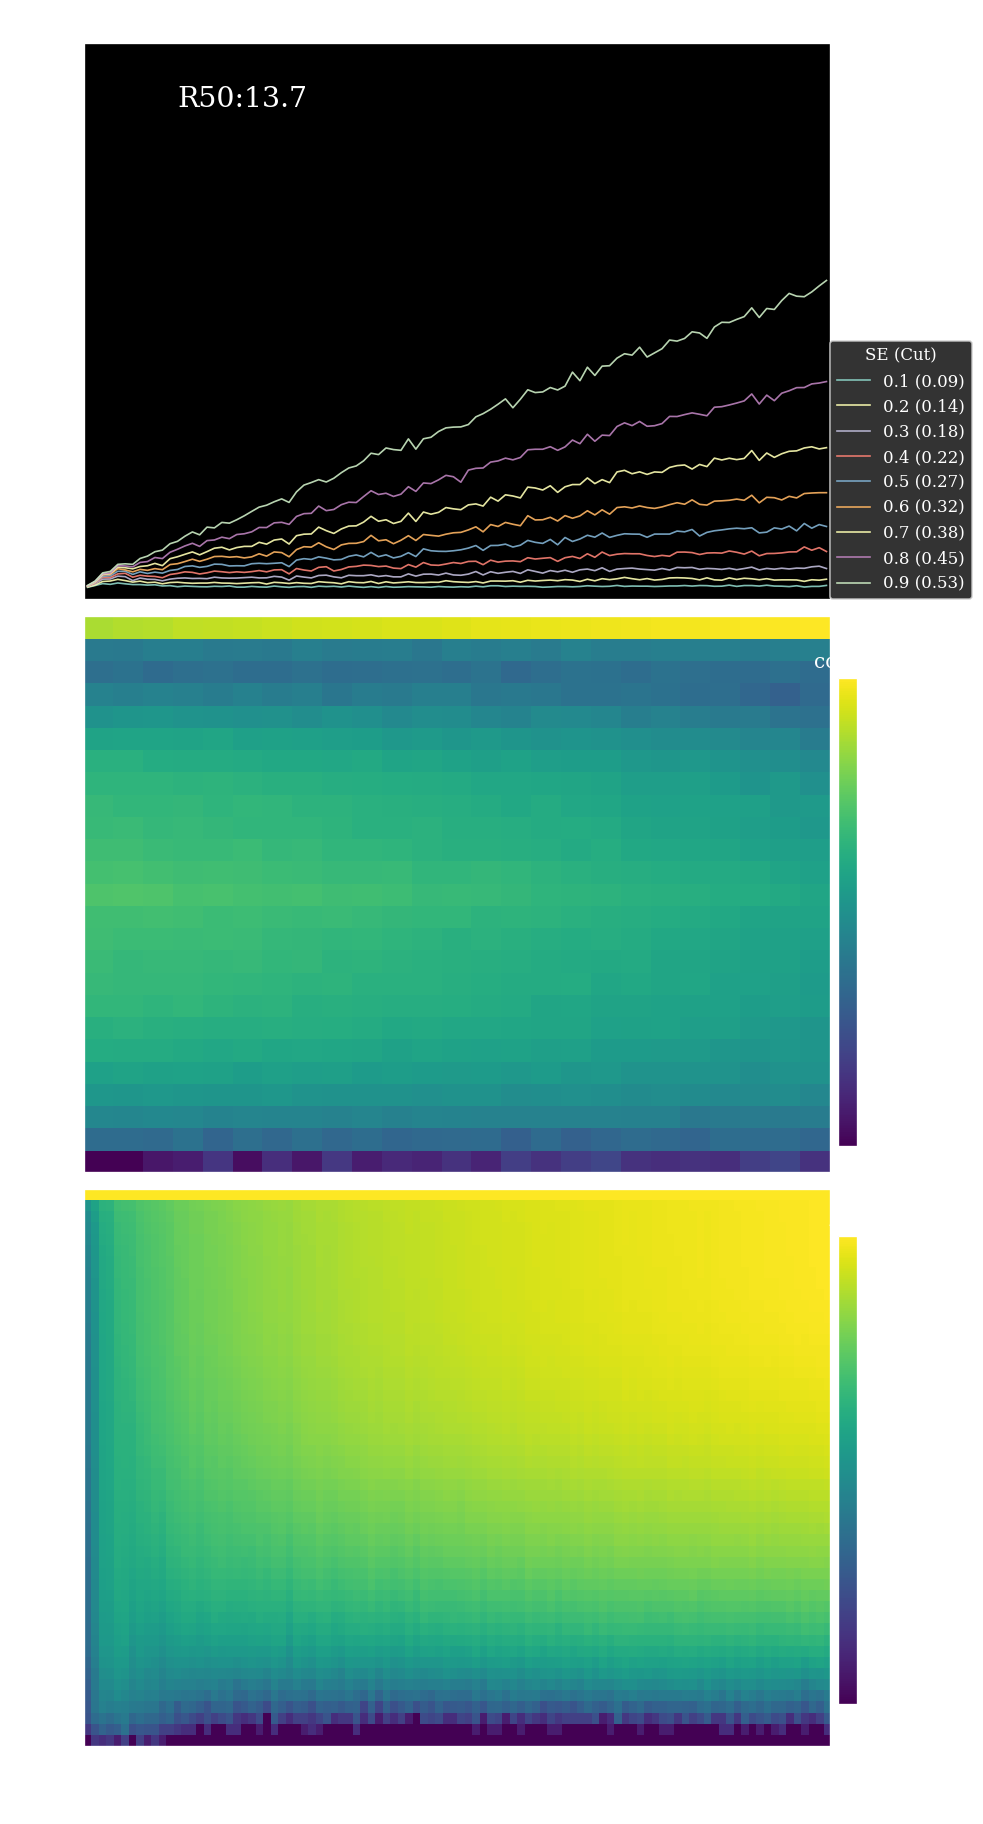

In [8]:
# MoDe order 1
for i,frac in enumerate([1,10,100]):
    torch.manual_seed(777)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=traindataset.samples.shape[1]).to(device)
    model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=20,order=1,
                                   background_only=True,epsilon=1)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.Adam(model_legendre.parameters(),lr=lr),
                       #log=logger,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    model_legendre.train(False)
    plot_stuff(model_legendre,Y=testTensor,
               title="MoDe[1] (str: {:d}, acc: {:.3})".format(frac, metrics_val_legendre.accs[-1]),
               bins=100)

Entering Training...
Epoch:0001/0100  (15.2 s)
 Train: loss:0.2367, acc:62.0% || Val: loss: 0.2139, acc:73.2%, R50: 10.8993, 1/JSD: 17.7995
Epoch:0100/0100  (1083.4s)
 Train: loss:0.1743, acc:81.1% || Val: loss: 0.1336, acc:81.0%, R50: 20.1926, 1/JSD: 6.1513


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


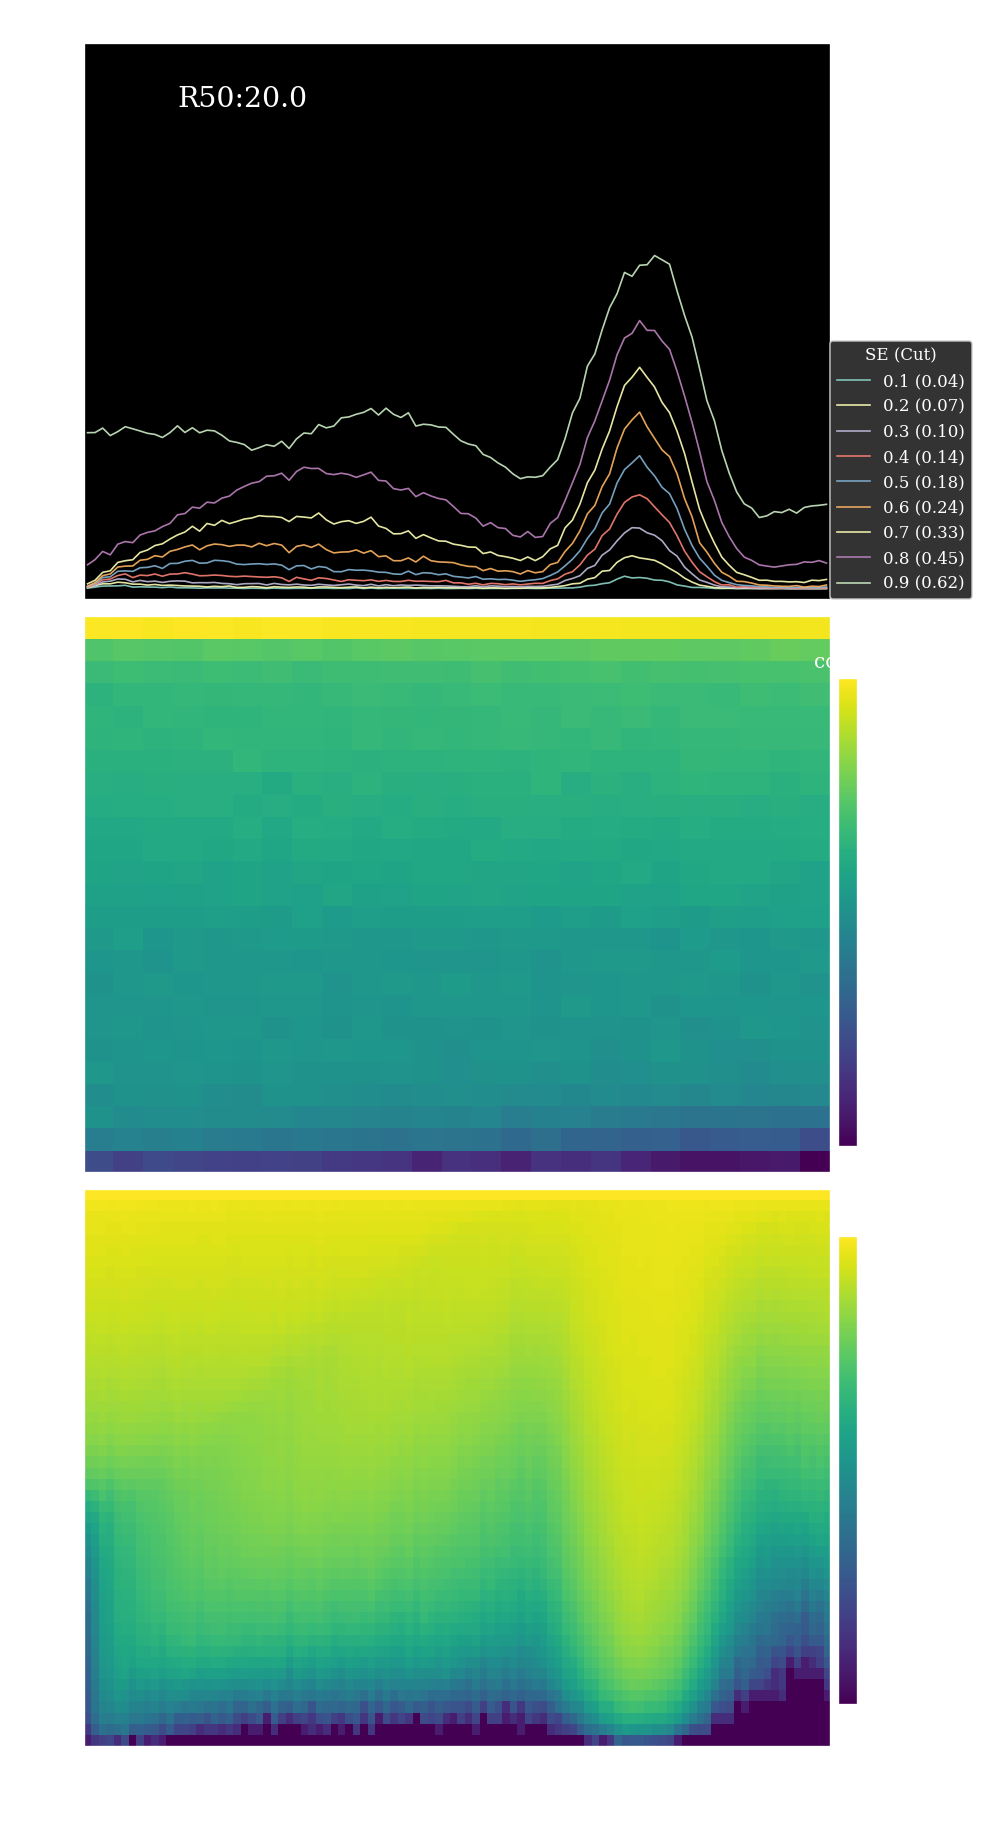

Entering Training...
Epoch:0001/0100  (14.6 s)
 Train: loss:0.6416, acc:29.6% || Val: loss: 0.5935, acc:30.0%, R50: 1.2242, 1/JSD: 2077.9927
Epoch:0100/0100  (1081.8s)
 Train: loss:0.2424, acc:79.1% || Val: loss: 0.1448, acc:79.1%, R50: 16.5510, 1/JSD: 9.5106


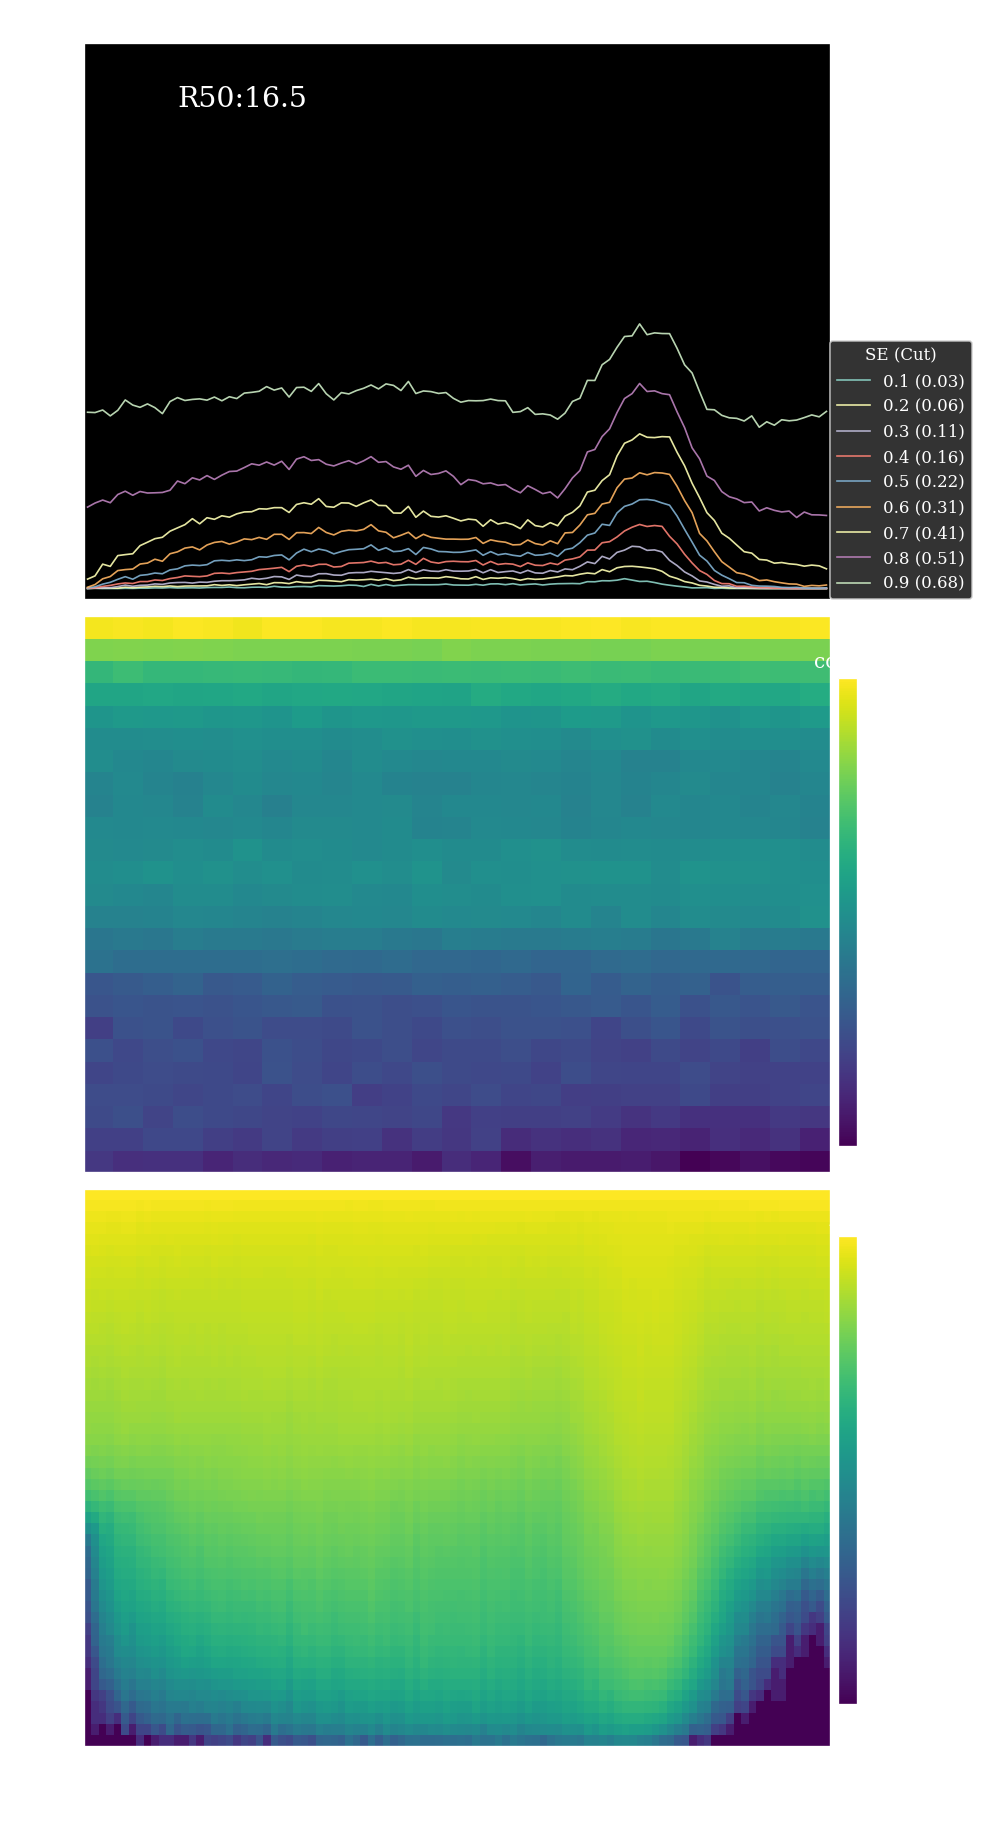

Entering Training...
Epoch:0001/0100  (14.6 s)
 Train: loss:1.1743, acc:27.3% || Val: loss: 0.6579, acc:27.4%, R50: 1.1830, 1/JSD: 2130.3043
Epoch:0100/0100  (1085.0s)
 Train: loss:-0.0278, acc:51.8% || Val: loss: 0.4518, acc:52.3%, R50: 12.7076, 1/JSD: 35.8316


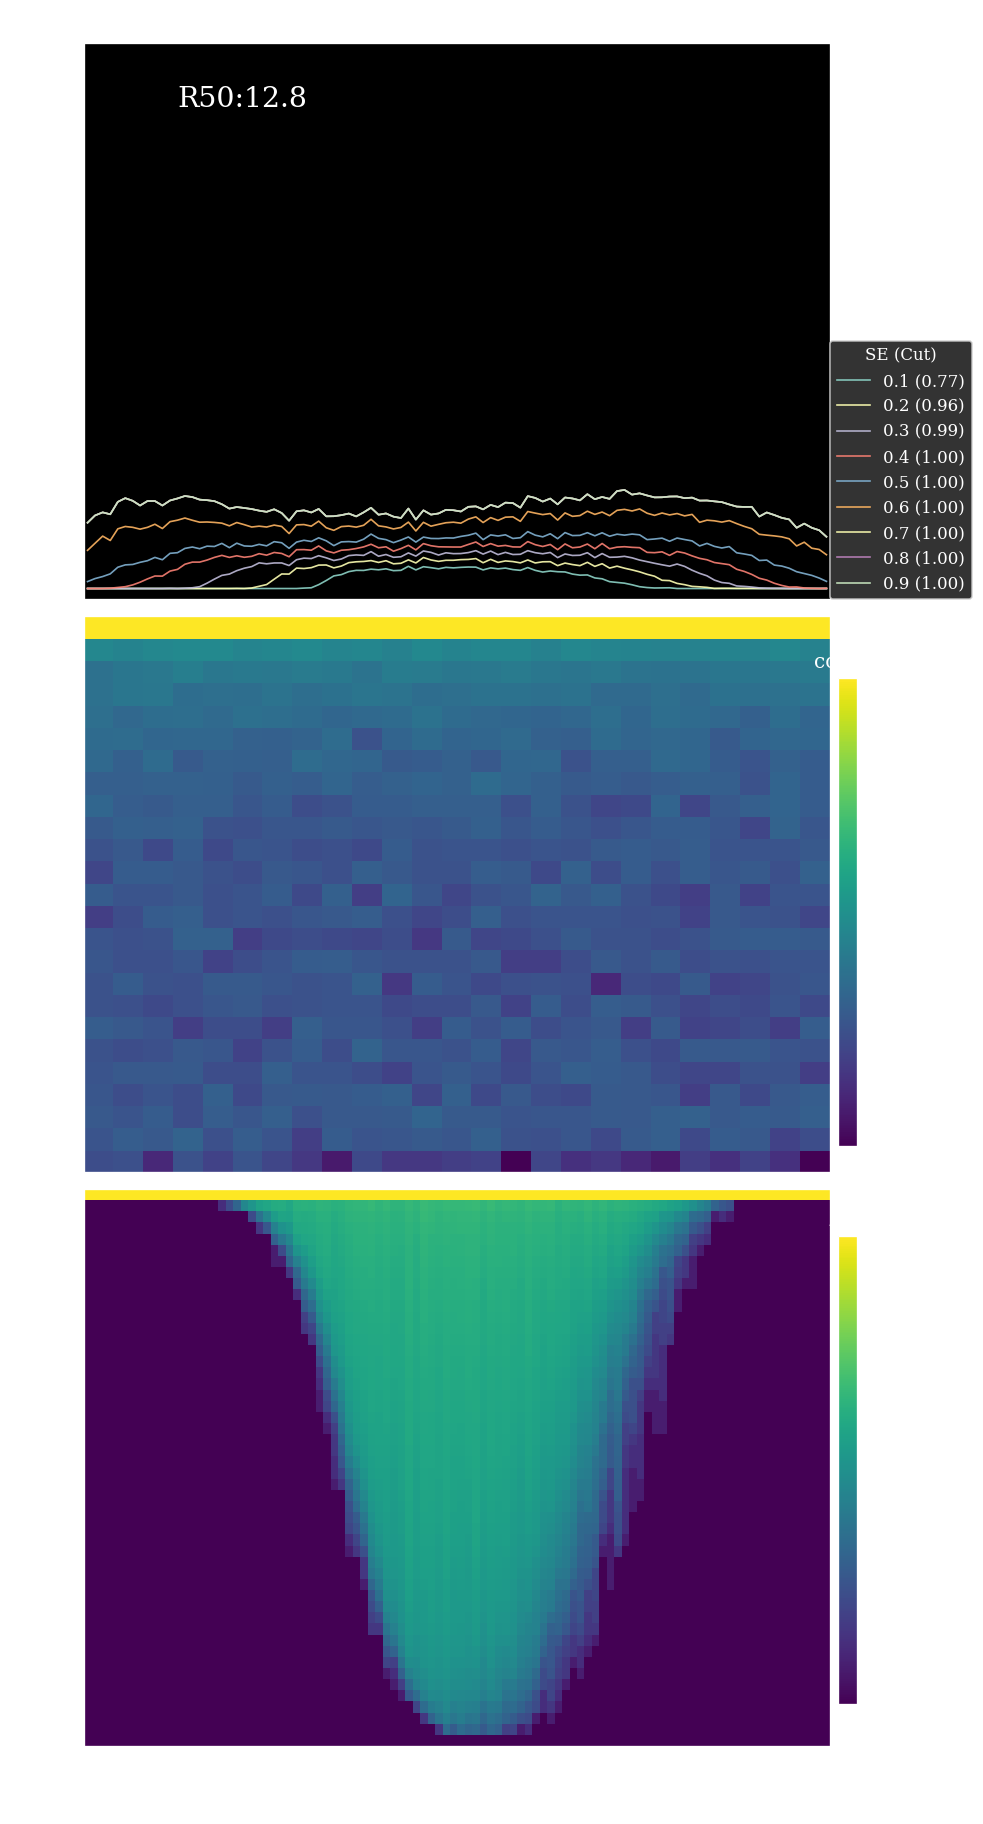

In [6]:
# DisCo
for i,frac in enumerate([1,10,100]):
    torch.manual_seed(777)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=traindataset.samples.shape[1]).to(device)
    model_legendre.loss = Disco(frac=frac,labels=traindataset.labels,background_only=True)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.Adam(model_legendre.parameters(),lr=lr),
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    model_legendre.train(False)
    plot_stuff(model_legendre,Y=testTensor,
               title="DisCo (str: {:d}, acc: {:.3})".format(frac, metrics_val_legendre.accs[-1]),
               bins=100)

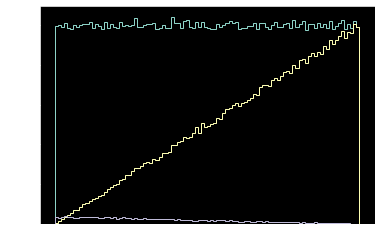

(0, 1)

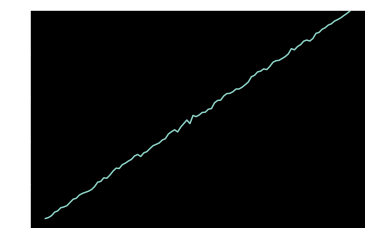

In [9]:
t,b,_ = plt.hist(m_b,histtype='step',density=False,bins=100)
c1,_,_ = plt.hist(m_b1[:250000],histtype='step',bins=b,density=False)
c2,_,_ = plt.hist(m_b2[:9000],histtype='step',bins=b,density=False)
plt.show()
plt.plot((b[1:]+b[:-1])/2,(c1+c2)/t)
plt.ylim([0,1])